# Testing FOOOF with Synthetic Data

Words, words, words.

ToDo:
    - Switch plots to violinplots
        - Tweak to plot across noise levels together, stop it extending density beyond the actual data
            - bw & cut
    - Update freqs & probs from MEG data
Decision:
    - absolute deviation, plot the distributions.
    
- Go to 1000 PSDs

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import sem

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.synth import gen_power_spectrum, gen_group_power_spectra, param_sampler
from fooof.analysis import get_band_peak_group

In [2]:
from syn_utils import *
from syn_plts import *

In [3]:
import random
random.seed(999)

## Check Generation

In [4]:
# Test generate a power spectrum
f_range = [3, 40]
bg = [0, 1]
osc = [10, 0.5, 2]
nlv = 0.
freq_res = 0.25

fs, ps = gen_power_spectrum(f_range, bg, osc, nlv, freq_res)

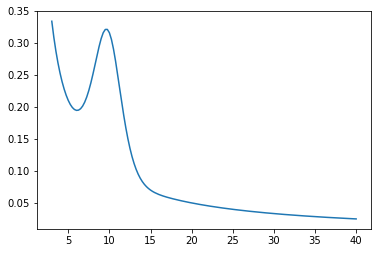

In [5]:
plt.plot(fs, ps)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.0321, 1.0210                                          
                                                                                                  
                                       1 peaks were found:                                        
          

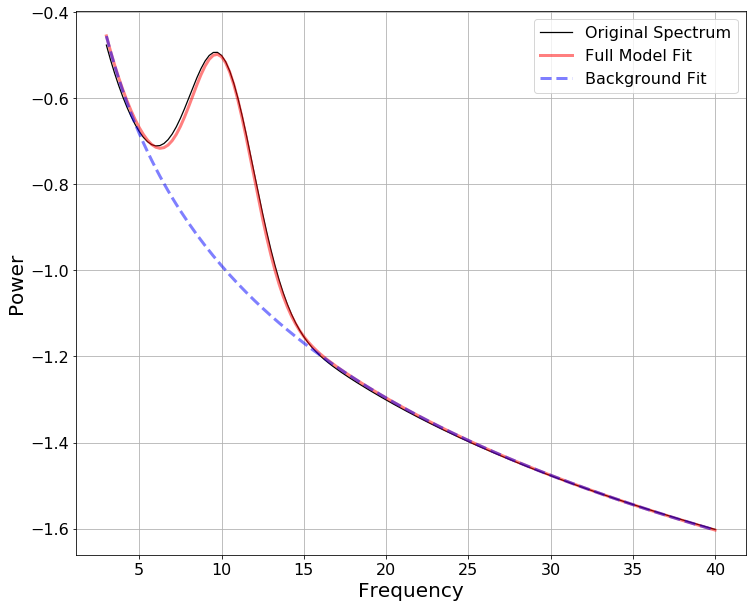

In [6]:
fm = FOOOF()
fm.report(fs, ps, plt_log=False)

In [7]:
# Compare actual parameters to FOOOF fit
print(bg, '\t', fm.background_params_)
print(osc, '\t', fm._gaussian_params)

[0, 1] 	 [ 0.03206982  1.0210163 ]
[10, 0.5, 2] 	 [[ 10.03786203   0.48589288   1.88526776]]


## Synthetic Generation Settings

Settings defined in syn_utils - check them. 

In [8]:
print_settings(N_OSCS_OPTS, N_OSCS_PROBS, '# of oscs')

Parameter definition for # of oscs 

	Value 	 Probability
	0 	 33.3%
	1 	 33.3%
	2 	 33.3%


In [9]:
print_settings(CF_OPTS, CF_PROBS, 'CFs')

Parameter definition for CFs 

	Value 	 Probability
	3 	 0.5%
	4 	 1.1%
	5 	 2.8%
	6 	 4.6%
	7 	 4.2%
	8 	 4.9%
	9 	 6.8%
	10 	 9.0%
	11 	 6.0%
	12 	 3.5%
	13 	 3.1%
	14 	 2.7%
	15 	 3.1%
	16 	 3.2%
	17 	 3.5%
	18 	 4.4%
	19 	 5.2%
	20 	 4.1%
	21 	 5.0%
	22 	 5.0%
	23 	 3.0%
	24 	 2.7%
	25 	 2.5%
	26 	 2.1%
	27 	 2.0%
	28 	 1.4%
	29 	 1.0%
	30 	 0.7%
	31 	 0.5%
	32 	 0.4%
	33 	 0.4%
	34 	 0.2%


In [10]:
print_settings(AMP_OPTS, AMP_PROBS, 'AMPs')

Parameter definition for AMPs 

	Value 	 Probability
	0.15 	 25.0%
	0.2 	 25.0%
	0.25 	 25.0%
	0.5 	 25.0%


In [11]:
print_settings(BW_OPTS, BW_PROBS, 'BWs')

Parameter definition for BWs 

	Value 	 Probability
	1.5 	 33.3%
	2.5 	 33.3%
	4 	 33.3%


In [12]:
print_settings(OFF_OPTS, OFF_PROBS, 'background offset')

Parameter definition for background offset 

	Value 	 Probability
	0 	 100.0%


In [13]:
print_settings(SL_OPTS, SL_PROBS, 'background slope')

Parameter definition for background slope 

	Value 	 Probability
	0.5 	 25.0%
	1 	 25.0%
	1.5 	 25.0%
	2 	 25.0%


In [14]:
# Sanity check probabilities are set correctly
for probs in [CF_PROBS, AMP_PROBS, BW_PROBS, OFF_PROBS, SL_PROBS]:
    assert np.isclose(sum(probs), 1, 1e-10)
print('All probabilities check out.')

All probabilities check out.


### Fitting Oscillations: 1 Oscillation Across Noise Levels

In [15]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6)

In [16]:
# Settings for PSD generation
f_range = [3, 40]
f_res = 0.25

n_psds = 10 # This is per condition

nlvs = [0.0000001, 0.025, 0.050, 0.075, 0.10, 0.15]
#bg = [1, 1]
#osc = [10, 0.5, 2]

peaks = gen_osc_def(1)
bgs = gen_bg_def()

In [17]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [18]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
syn_params = [None] * n_nlvs

for n_ind, nlv in enumerate(nlvs):
    freqs, psds[n_ind, :, :], syn_params[n_ind] = gen_group_power_spectra(n_psds, f_range, bgs, peaks, nlv, 0.25)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (6, 10, 149)


In [19]:
# Extract ground truth values
osc_truths = []; bg_truths = []

for ind, nlv_params in enumerate(syn_params):
    osc_truths.append([psd_params.gaussian_params for psd_params in nlv_params])
    bg_truths.append([psd_params.background_params for psd_params in nlv_params])

osc_truths = np.array(osc_truths)
bg_truths = np.array(bg_truths)

In [20]:
# Fit power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

In [21]:
# Extract data of interest from FOOOF fits
osc_fits = []; bg_fits = []; err_fits = []; r2_fits = []; n_oscs = []

for fg in fgs:
    osc_fits.append(get_band_peak_group(fg.get_all_data('gaussian_params'), [3, 40], len(fg)))
    bg_fits.append(fg.get_all_data('background_params'))
    err_fits.append(fg.get_all_data('error'))
    r2_fits.append(fg.get_all_data('r_squared'))
    n_oscs.append([fres.gaussian_params.shape[0] for fres in fg])

osc_fits = np.array(osc_fits)
bg_fits = np.array(bg_fits)
err_fits = np.array(err_fits)
r2_fits = np.array(r2_fits)
n_oscs = np.array(n_oscs)

In [22]:
#
osc_errors = np.abs(osc_truths - osc_fits) # absolute deviation
bg_errors = np.abs(bg_truths - bg_fits)

#osc_errors = (osc_truths - osc_fits)**2   # squared error
#bg_errors = (bg_truths - bg_fits)**2

In [23]:
# Pull out error per oscillations parameter
cf_errors = osc_errors[:, :, 0]
amp_errors = osc_errors[:, :, 1]
bw_errors = osc_errors[:, :, 2]

# Pull out error per background parameter
off_errors = bg_errors[:, :, 0]
sl_errors = bg_errors[:, :, 1]

In [24]:
# Plot Settings
#avg = 'mean'
avg = 'median'

err = 'sem'

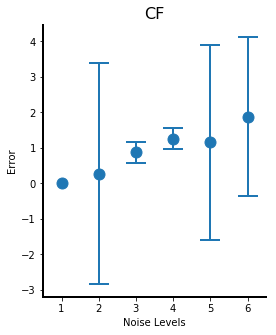

In [25]:
plot_errors(cf_errors, 'CF', avg, err)

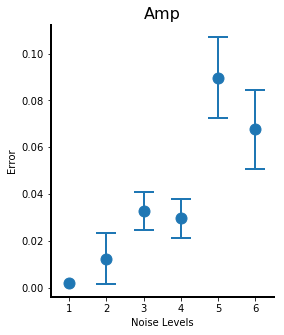

In [26]:
plot_errors(amp_errors, 'Amp', avg, err)

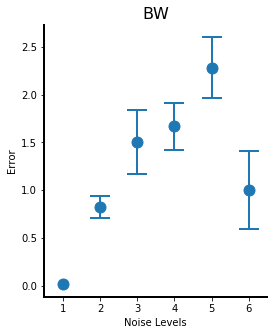

In [27]:
plot_errors(bw_errors, 'BW', avg, err)

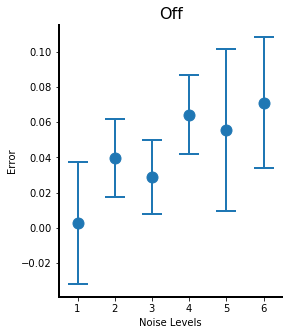

In [28]:
plot_errors(off_errors, 'Off', avg, err)

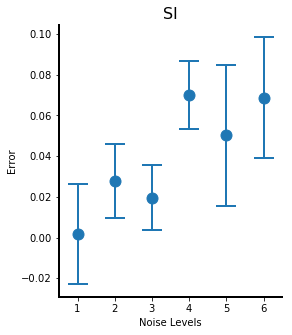

In [29]:
plot_errors(sl_errors, 'Sl', avg, err)

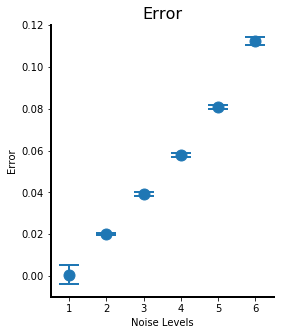

In [30]:
plot_errors(err_fits, 'Error', avg, err)

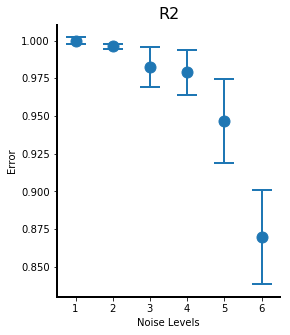

In [31]:
plot_errors(r2_fits, 'R2', avg, err)

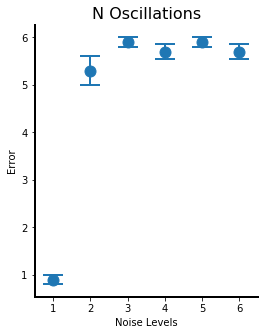

In [32]:
plot_errors(n_oscs, 'N Oscillations')

In [33]:
import seaborn as sns

In [34]:
dat = bw_errors[1, :]
dat.shape

(10,)

In [35]:
np.min(dat)

0.15757837910869865

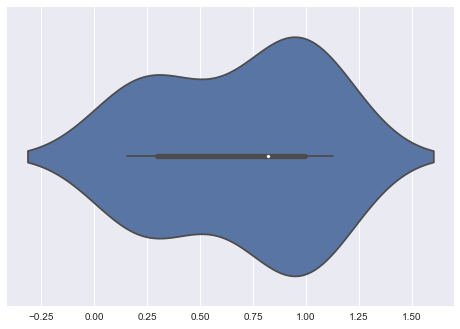

In [36]:
sns.violinplot(dat)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a21635780>],
 'cbars': <matplotlib.collections.LineCollection at 0x1a2163c630>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a21635668>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a2163c358>}

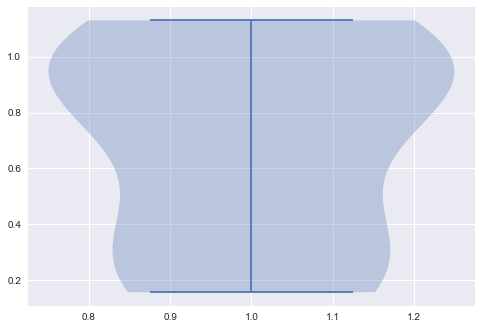

In [37]:
plt.violinplot(dat)

In [38]:
fm_nlv1 = fgs[0].get_fooof(0, True)
fm_nlv5 = fgs[4].get_fooof(0, True)

SynParams(background_params=[0, 1.0], gaussian_params=[14, 0.5, 1.5], nlv=1e-07)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.0017, 1.0009                                          
                                                                                                  
                            

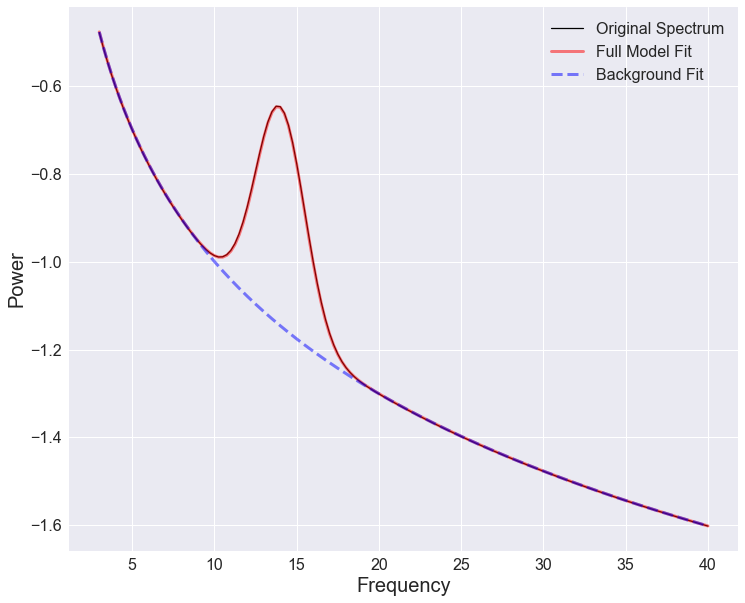

In [39]:
print(syn_params[0][0])
fm_nlv1.print_results()
fm_nlv1.plot()

SynParams(background_params=[0, 1.0], gaussian_params=[30, 0.20000000000000001, 1.5], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -0.0148, 0.5100                                          
                                                                                                  
             

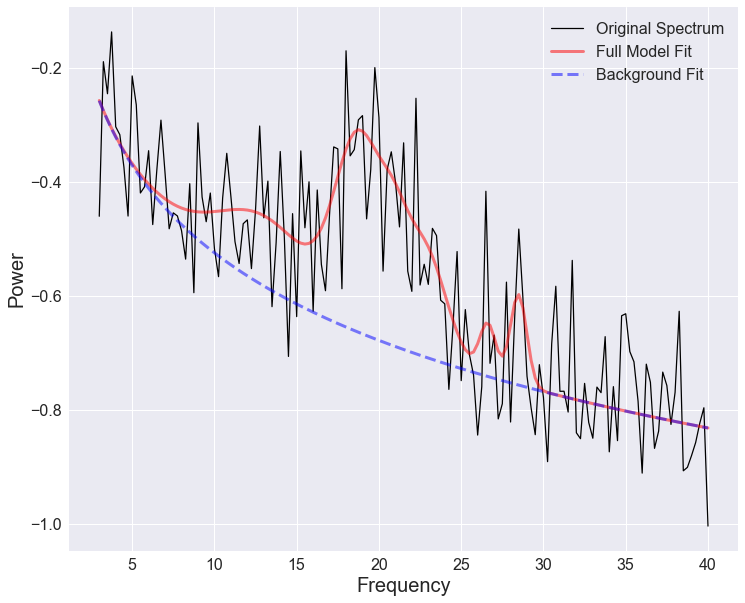

In [40]:
print(syn_params[-1][0])
fm_nlv5.print_results()
fm_nlv5.plot()

### Check error for multiple peaks

In [41]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6)

In [42]:
## Tests

from random import choice

def im_a_generator(params):
    while True:
        yield choice(params)
        
def im_callable(params):
    return choice(params)
    #return params[np.random.randint(len(params))]

def test_call(call_me):
    print(im_callable([1, 2, 3]))
    
test_call(im_callable)

3
